# Distribution-abundance Train and Test (Optimize R Squared)

**Written by Timm Nawrocki**

*Last updated Saturday, November 16, 2019.*

In [1]:
# -*- coding: utf-8 -*-
# ---------------------------------------------------------------------------
# Distribution-abundance Train and Test
# Author: Timm Nawrocki, Alaska Center for Conservation Science
# Created on: 2020-05-14
# Usage: Must be executed as a Jupyter Notebook in an Anaconda 3 installation.
# Description: "Distribution-Abundance Train and Test" trains a classifier to predict species presence and absence and trains a regressor to predict species abundance within areas of predicted presence. The predictions are composited into a single continuous output that can theoretically range from 0 to 100 representing percent cover. All model performance metrics are calculated on independent test partitions.
# ---------------------------------------------------------------------------

## 1. Introduction

This script runs the model train and test steps to output a model performance and variable importance report, trained classifier file, trained regressor file, and threshold files that can be transferred to the predict script. The train-test classifier and regressor are set to use 4 cores. The script must be run on a machine that can support 4 cores. The final classifier and regressor in this script are set to use 1 core to provide the most cost efficient, rather than the fastest, model prediction. For information on generating inputs for this script or on setting up Google Cloud virtual machines, see the [project readme](https://github.com/accs-uaa/vegetation-cover-modeling).

The distribution and abundance of a species is two distinct problems: 1. Where does the species occur? 2. Where the species occurs, how much is present? To represent the nested nature of the problems, we developed a hierarchical model where a classifier predicted species presence-absence and a regressor predicted species abundance in areas of predicted species presence. The practical advantage to this hierarchical method is that it accurately predicts absences, which are of disproportionate ecological value than exact prediction of other values along the gradient.

## 2. Import Data and Variables

This script relies on data that has been pre-processed into a csv file using the "Format Taxon Data" ArcGIS Pro script tool. The csv file must include all presence and absence observations for the target taxon or aggregate and all values for features extracted to the site locations. Features defined below must be modified to match the input csv file if changes to the construction of features are made.

In [2]:
# Import os
import os

In [3]:
# Set root directory
root_folder = 'N:/ACCS_Work'
# Define data folders
data_input = os.path.join(root_folder,
                          'Projects/VegetationEcology/AKVEG_QuantitativeMap/Project_GIS/Data_Input/species_data')
data_output = os.path.join(root_folder,
                           'Projects/VegetationEcology/AKVEG_QuantitativeMap/Project_GIS/Data_Output/model_results')

In [4]:
# Define input file
input_file = os.path.join(data_input, 'mapClass_PiceaGlauca.csv')
# Define output folder
output_folder = os.path.join(data_output, 'picgla_r2')
# Define output report
output_report_name = 'picea-glauca-report.html'
# Define species, genera, or aggregate name
taxon_name = 'Picea glauca'

In [5]:
# Define variable sets
predictor_all = ['aspect', 'wetness', 'elevation', 'slope', 'roughness', 'exposure', 'area', 'relief', 'position', 'radiation', 'sent2_05_11_shortIR1', 'sent2_05_12_shortIR2', 'sent2_05_2_blue', 'sent2_05_3_green', 'sent2_05_4_red', 'sent2_05_5_redge1', 'sent2_05_6_redge2', 'sent2_05_7_redge3', 'sent2_05_8_nearIR', 'sent2_05_8a_redge4', 'sent2_05_evi2', 'sent2_05_nbr', 'sent2_05_ndmi', 'sent2_05_ndsi', 'sent2_05_ndvi', 'sent2_05_ndwi', 'sent2_06_11_shortIR1', 'sent2_06_12_shortIR2', 'sent2_06_2_blue', 'sent2_06_3_green', 'sent2_06_4_red', 'sent2_06_5_redge1', 'sent2_06_6_redge2', 'sent2_06_7_redge3', 'sent2_06_8_nearIR', 'sent2_06_8a_redge4', 'sent2_06_evi2', 'sent2_06_nbr', 'sent2_06_ndmi', 'sent2_06_ndsi', 'sent2_06_ndvi', 'sent2_06_ndwi', 'sent2_07_11_shortIR1', 'sent2_07_12_shortIR2', 'sent2_07_2_blue', 'sent2_07_3_green', 'sent2_07_4_red', 'sent2_07_5_redge1', 'sent2_07_6_redge2', 'sent2_07_7_redge3', 'sent2_07_8_nearIR', 'sent2_07_8a_redge4', 'sent2_07_evi2', 'sent2_07_nbr', 'sent2_07_ndmi', 'sent2_07_ndsi', 'sent2_07_ndvi', 'sent2_07_ndwi', 'sent2_08_11_shortIR1', 'sent2_08_12_shortIR2', 'sent2_08_2_blue', 'sent2_08_3_green', 'sent2_08_4_red', 'sent2_08_5_redge1', 'sent2_08_6_redge2', 'sent2_08_7_redge3', 'sent2_08_8_nearIR', 'sent2_08_8a_redge4', 'sent2_08_evi2', 'sent2_08_nbr', 'sent2_08_ndmi', 'sent2_08_ndsi', 'sent2_08_ndvi', 'sent2_08_ndwi', 'sent2_09_11_shortIR1', 'sent2_09_12_shortIR2', 'sent2_09_2_blue', 'sent2_09_3_green', 'sent2_09_4_red', 'sent2_09_5_redge1', 'sent2_09_6_redge2', 'sent2_09_7_redge3', 'sent2_09_8_nearIR', 'sent2_09_8a_redge4', 'sent2_09_evi2', 'sent2_09_nbr', 'sent2_09_ndmi', 'sent2_09_ndsi', 'sent2_09_ndvi', 'sent2_09_ndwi', 'lst_05', 'lst_06', 'lst_07', 'lst_08', 'lst_09']
zero_variable = ['zero']
cover = ['coverTotal']
retain_variables = ['siteCode', 'day', 'year', 'nameAccepted', 'genus', 'initialProject', 'coverType', 'coverMethod', 'scopeVascular', 'scopeBryophyte', 'scopeLichen', 'plotDimensions', 'datum', 'latitude', 'longitude', 'error', 'num_points']
all_variables = retain_variables + predictor_all + cover
iteration = ['iteration']
absence = ['absence']
presence = ['presence']
response = ['response']
distribution = ['distribution']
prediction = ['prediction']
output_variables = all_variables + absence + presence + response + distribution + prediction + iteration

## 3. Initialize

This script has general dependencies on the *os* package for file system manipulations, the *numpy* and *pandas* packages for data manipulations, and the *seaborn* and *matplotlib* packages for plotting. *GPy* and *GPyOpt* are Gaussian Process packages that drive the bayesian optimization of hyperparameters. *XGBoost* provides the gradient boosting classifier and regressor used to create the composite predictions. *Scikit Learn* provides model selection, cross validation, performance tools. Joblib provides a function to save models.

In [6]:
# Import packages for file manipulation, data manipulation, and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plot
# Import packages for bayesian optimization
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization
# Import LightGBM gradient boosting implementations
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
# Import modules for model selection, cross validation, random forest, and performance from Scikit Learn
from sklearn.utils import shuffle
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
# Import joblib
import joblib
# Import timing packages
import time
import datetime

In [7]:
# Create a plots folder if it does not exist
plots_folder = os.path.join(output_folder, "plots")
if not os.path.exists(plots_folder):
    os.makedirs(plots_folder)

In [8]:
# Define output test data
output_csv = os.path.join(output_folder, 'prediction.csv')
# Define output model files
output_classifier = os.path.join(output_folder, 'classifier.joblib')
output_regressor = os.path.join(output_folder, 'regressor.joblib')
# Define output threshold file
threshold_file = os.path.join(output_folder, 'threshold.txt')
# Define output correlation plot
variable_correlation = os.path.join(plots_folder, "variable_correlation.png")
# Define output variable importance plots
importance_classifier = os.path.join(plots_folder, "importance_classifier.png")
importance_regressor = os.path.join(plots_folder, "importance_regressor.png")
# Define output bayesian optimization convergence plots
convergence_classifier = os.path.join(plots_folder, "convergence_classifier.png")
convergence_regressor = os.path.join(plots_folder, "convergence_regressor.png")

## 4. Functions

Analyses are conducted in units represented by functions. The functions are defined below in order of use. In general, functions in this script fall into three categories: Bayesian Optimization, Threshold Optimization, and Export Results.

### 4.1. Bayesian Optimization Functions

In [9]:
# Define an optimization objective function for the xgboost classifier
def cvClassifier(parameters):
    # Define a 5-fold cross validation split method
    cv_splits = KFold(n_splits=10, shuffle=False, random_state=314)
    # Define the search parameter set
    parameters = parameters[0]
    # Define the cross validator
    score = cross_val_score(
        LGBMClassifier(boosting_type='gbdt',
                       num_leaves=int(parameters[0]),
                       max_depth=int(parameters[1]),
                       learning_rate=.05,
                       n_estimators=100,
                       subsample_for_bin=200000,
                       objective='binary',
                       class_weight=None,
                       min_split_gain = parameters[2],
                       min_child_weight = parameters[3],
                       min_child_samples = int(parameters[4]),
                       subsample = parameters[5],
                       subsample_freq = 1,
                       colsample_bytree = parameters[6],
                       reg_alpha = parameters[7],
                       reg_lambda = parameters[8],
                       n_jobs = 16,
                       silent = True,
                       importance_type = 'gain'),
        X_bayesian, y_bayesian, scoring='roc_auc', cv=cv_splits).mean()
    # Convert the mean score to array and return the inverse of the array for minimization
    score = np.array(score)
    return -score

In [10]:
# Define an optimization objective function for the xgboost regressor
def cvRegressor(parameters):
    # Define a 5-fold cross validation split method
    cv_splits = KFold(n_splits=10, shuffle=False, random_state=314)
    # Define the search parameter set
    parameters = parameters[0]
    # Define the cross validator
    score = cross_val_score(
        LGBMRegressor(boosting_type='gbdt',
                      num_leaves=int(parameters[0]),
                      max_depth=int(parameters[1]),
                      learning_rate=.05,
                      n_estimators=100,
                      subsample_for_bin=200000,
                      objective='regression',
                      class_weight=None,
                      min_split_gain = parameters[2],
                      min_child_weight = parameters[3],
                      min_child_samples = int(parameters[4]),
                      subsample = parameters[5],
                      subsample_freq = 1,
                      colsample_bytree = parameters[6],
                      reg_alpha = parameters[7],
                      reg_lambda = parameters[8],
                      n_jobs = 16,
                      silent = True,
                      importance_type = 'gain'),
        X_bayesian, y_bayesian, scoring='r2', cv=cv_splits).mean()
    # Convert the mean score to array and return the inverse of the array for minimization
    score = np.array(score)
    return -score

In [11]:
# Define an optimization function
def bayesianOptimizer(objective_function, initial, iterations, plot_file):
    # Create the hyperparameter search domain
    domain=[{'name': 'num_leaves', 'type': 'discrete', 'domain': (7, 100)},
            {'name': 'max_depth', 'type': 'discrete', 'domain': (3, 30)},
            {'name': 'min_split_gain', 'type': 'continuous', 'domain': (0, 0.1)},
            {'name': 'min_child_weight', 'type': 'continuous', 'domain': (0, 1)},
            {'name': 'min_child_samples', 'type': 'continuous', 'domain': (1, 200)},
            {'name': 'subsample', 'type': 'continuous', 'domain': (.1, .9)},
            {'name': 'colsample_bytree', 'type': 'continuous', 'domain': (.1, .9)},
            {'name': 'reg_alpha', 'type': 'continuous', 'domain': (0, 5)},
            {'name': 'reg_lambda', 'type': 'continuous', 'domain': (0, 5)},
           ]
    # Initialize the Bayesian Optimizer
    optimizer = GPyOpt.methods.BayesianOptimization(f = objective_function,
                                                    domain = domain,
                                                    model_type = 'GP',
                                                    initial_design_numdata = initial,
                                                    initial_design_type = 'random',
                                                    acquisition_type = 'EI',
                                                    exact_feval=False,
                                                    maximize=False)
    # Run iterations of optimization
    optimizer.run_optimization(max_iter=iterations)
    # Plot convergence
    optimizer.plot_convergence(filename=plot_file)
    # Return results
    return optimizer

### 4.2. Threshold Optimization Functions

In [12]:
# Define a function to calculate performance metrics based on a specified threshold value
def testPresenceThreshold(predict_probability, threshold, y_test):
    # Create an empty array of zeroes that matches the length of the probability predictions
    predict_thresholded = np.zeros(predict_probability.shape)
    # Set values for all probabilities greater than or equal to the threshold equal to 1
    predict_thresholded[predict_probability >= threshold] = 1
    # Determine error rates
    confusion_test = confusion_matrix(y_test, predict_thresholded)
    true_negative = confusion_test[0,0]
    false_negative = confusion_test[1,0]
    true_positive = confusion_test[1,1]
    false_positive = confusion_test[0,1]
    # Calculate sensitivity and specificity
    sensitivity = true_positive / (true_positive + false_negative)
    specificity = true_negative / (true_negative + false_positive)
    # Calculate AUC score
    auc = roc_auc_score(y_test, predict_probability)
    # Calculate overall accuracy
    accuracy = (true_negative + true_positive) / (true_negative + false_positive + false_negative + true_positive)
    # Return the thresholded probabilities and the performance metrics
    return (sensitivity, specificity, auc, accuracy)

In [13]:
# Create a function to determine a presence threshold
def determineOptimalThreshold(predict_probability, y_test):
    # Iterate through numbers between 0 and 1000 to output a list of sensitivity and specificity values per threshold number
    i = 1
    sensitivity_list = []
    specificity_list = []
    while i < 1001:
        threshold = i/1000
        sensitivity, specificity, auc, accuracy = testPresenceThreshold(predict_probability, threshold, y_test)
        sensitivity_list.append(sensitivity)
        specificity_list.append(specificity)
        i = i + 1
    # Calculate a list of absolute value difference between sensitivity and specificity and find the optimal threshold
    difference_list = [np.absolute(a - b) for a, b in zip(sensitivity_list, specificity_list)]
    value, threshold = min((value, threshold) for (threshold, value) in enumerate(difference_list))
    threshold = threshold/1000
    # Calculate the performance of the optimal threshold
    sensitivity, specificity, auc, accuracy = testPresenceThreshold(predict_probability, threshold, y_test)
    # Return the optimal threshold and the performance metrics of the optimal threshold
    return threshold, sensitivity, specificity, auc, accuracy

### 4.3. Export Results Functions

In [14]:
# Create a function to composite model results
def compositePrediction(test, presence, response, threshold):
    # Define a function to threshold absences and set presences equal to regression response
    def compositeRows(row):
        if row[presence[0]] < threshold:
            return 0
        elif row[presence[0]] >= threshold:
            return row[response[0]]
    # Apply function to all rows in test data
    test['prediction'] = test.apply(lambda row: compositeRows(row), axis=1)
    # Return the test data frame with composited results
    return test

In [15]:
# Define a function to plot Pearson correlation of predictor variables
def plotVariableCorrelation(X_train, outFile):
    # Calculate Pearson correlation coefficient between the predictor variables, where -1 is perfect negative correlation and 1 is perfect positive correlation
    correlation = X_train.astype('float64').corr()
    # Generate a mask for the upper triangle of plot
    mask = np.zeros_like(correlation, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plot.subplots(figsize=(20, 18))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    correlation_plot = sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={'shrink': .5})
    correlation_figure = correlation_plot.get_figure()
    correlation_figure.savefig(outFile, bbox_inches='tight', dpi=300)
    # Clear plot workspace
    plot.clf()
    plot.close()

In [16]:
# Define a function to plot variable importances
def plotVariableImportances(inModel, X_train, outVariableFile):
    # Get numerical feature importances
    importances = list(inModel.feature_importances_)
    # List of tuples with variable and importance
    feature_list = list(X_train.columns)
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Initialize the plot and set figure size
    variable_figure = plot.figure()
    fig_size = plot.rcParams["figure.figsize"]
    fig_size[0] = 20
    fig_size[1] = 6
    plot.rcParams["figure.figsize"] = fig_size
    # Create list of x locations for plotting
    x_values = list(range(len(importances)))
    # Make a bar chart of the variable importances
    plot.bar(x_values, importances, orientation = 'vertical')
    # Tick labels for x axis
    plot.xticks(x_values, feature_list, rotation='vertical')
    # Axis labels and title
    plot.ylabel('Importance'); plot.xlabel('Variable'); plot.title('Variable Importances');
    # Export
    variable_figure.savefig(outVariableFile, bbox_inches="tight", dpi=300)
    # Clear plot workspace
    plot.clf()
    plot.close()

## 5. Conduct Analyses

The analyses are subdivided into subsections: load data, assess untuned model performance, test bayesian optimization, train and test iterations with nested cross validation, final model training, and export results. The majority of analytical time is devoted to bayesian optimization within nested cross validation to ensure selection of a best performing model. Nested cross-validation is necessary to maintain the independence of the test data outside of cross-validated hyperparameter and threshold optimization. The XGBoost implementation of stochastic gradient boosting is the learning algorithm. The composited prediction results of the outer cross-validation, wherein each sample is predicted a single time, are appended into a single data frame for additional analyses and plotting external to this script.

Outputs of the analysis are:
1. Report of performance, including the following plots:
  1. Final convergence of the classifier hyperparameters
  2. Final convergence of the regressor hyperparameters
  3. Final variable importances of the classifier
  4. Final variable importances of the regressor
  5. Pearson correlation for all predictors
2. Model files:
  1. Final Classifier
  2. Final Regressor
3. Report with overall R squared, Mean Absolute Error (MAE), Root Mean Squared Error (RMSE) and absence AUC and accuracy.
4. Final threshold
5. Test predictions from 10-fold cross-validation (each sample predicted once)

### 5.1. Load Data

Two data instances were created based on the input csv file: an input data frame and a presence only AIM NPR-A data subset. The presence-absence classifiers were trained from the input data and the abundance regressors were trained from the presence AIM data.

In [17]:
# Create data frame of input data
input_data = pd.read_csv(input_file)
# Convert values to floats
input_data[predictor_all + cover] = input_data[predictor_all + cover].astype(float)
# Convert values to integers
input_data[zero_variable] = input_data[zero_variable].astype('int32')
# Shuffle data
input_data = shuffle(input_data, random_state=21)

In [18]:
# Split the X data for classification
X_classify = input_data[predictor_all]
# Split the y data for classification
y_classify = input_data[zero_variable[0]].astype('int32')

In [19]:
# Subset the training data to presences
cover_data = input_data[(input_data['coverType'] == 'Quantitative') | (input_data['coverType'] == 'Semi-quantitative')]
cover_data = cover_data.reset_index()
non_cover_data = input_data[(input_data['coverType'] != 'Quantitative') & (input_data['coverType'] != 'Semi-quantitative')]
non_cover_data = non_cover_data.reset_index()
presence_data = cover_data[cover_data['zero'] == 1]

In [20]:
# Split the X and y data for regression
X_regress = presence_data[predictor_all]
y_regress = presence_data[cover[0]]

In [21]:
# Set initial plot sizefig_size = plot.rcParams["figure.figsize"]
fig_size = plot.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plot.rcParams["figure.figsize"] = fig_size
plot.style.use('grayscale')

### 5.2. Train and Test Iterations

In [22]:
# Define 10-fold cross validation split methods
outer_cv_splits = KFold(n_splits=10, shuffle=True, random_state=314)
inner_cv_splits = KFold(n_splits=10, shuffle=False, random_state=314)

In [23]:
# Create empty lists to store threshold and performance metrics
threshold_list = []
# Create an empty data frame to store the outer cross validation splits
outer_train = pd.DataFrame(columns=all_variables + iteration)
outer_test = pd.DataFrame(columns=all_variables + iteration)

In [24]:
# Create an empty data frame to store the outer test results
outer_results = pd.DataFrame(columns=output_variables)

In [25]:
# Create outer cross validation splits for cover data
count = 1
for train_index, test_index in outer_cv_splits.split(cover_data):
    # Split the data into train and test partitions
    train = cover_data.iloc[train_index]
    test = cover_data.iloc[test_index]
    # Insert iteration to train
    train[iteration[0]] = count
    # Insert iteration to test
    test[iteration[0]] = count
    # Append to data frames
    outer_train = outer_train.append(train, ignore_index=True, sort=True)
    outer_test = outer_test.append(test, ignore_index=True, sort=True)
    # Increase counter
    count += 1

In [26]:
# Create outer cross validation splits for non-cover data
count = 1
for train_index, test_index in outer_cv_splits.split(non_cover_data):
    # Split the data into train and test partitions
    train = non_cover_data.iloc[train_index]
    test = non_cover_data.iloc[test_index]
    # Insert iteration to train
    train[iteration[0]] = count
    # Insert iteration to test
    test[iteration[0]] = count
    # Append to data frames
    outer_train = outer_train.append(train, ignore_index=True, sort=True)
    outer_test = outer_test.append(test, ignore_index=True, sort=True)
    # Increase counter
    count += 1

In [27]:
# Reset indices
outer_train = outer_train.reset_index()
outer_test = outer_test.reset_index()

Conducting outer cross-validation iteration 1 of 10...
	Optimizing classifier hyperparameters...
	Completed at 2020-05-17 19:41 (Elapsed time: 0:03:23)
	----------
	Optimizing classification threshold...
	Completed at 2020-05-17 19:41 (Elapsed time: 0:00:20)
	----------
	Training classifier...
	Completed at 2020-05-17 19:41 (Elapsed time: 0:00:00)
	----------
	Optimizing regressor hyperparameters...
	Completed at 2020-05-17 19:43 (Elapsed time: 0:01:23)
	----------
	Training regressor...
	Completed at 2020-05-17 19:43 (Elapsed time: 0:00:00)
	----------
	Predicting outer cross-validation test data...
	Completed at 2020-05-17 19:43 (Elapsed time: 0:00:00)
	----------
Conducting outer cross-validation iteration 2 of 10...
	Optimizing classifier hyperparameters...


KeyboardInterrupt: 

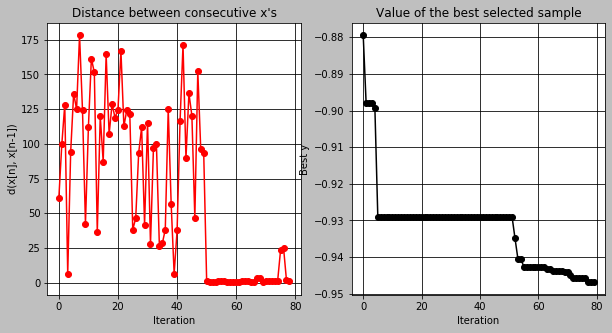

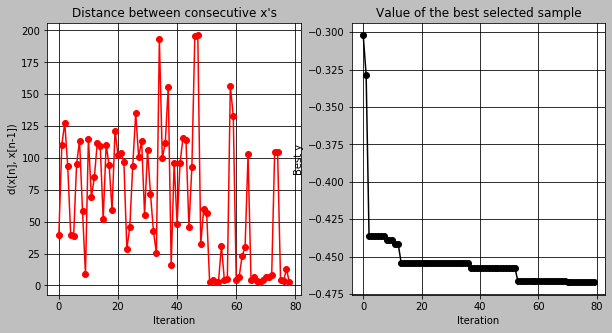

In [28]:
#### MODEL TRAIN AND TEST ITERATIONS WITH HYPERPARAMETER AND THRESHOLD OPTIMIZATION IN NESTED CROSS-VALIDATION
####____________________________________________________

# Iterate through outer cross validation splits
i = 1
while i < 11:
    
    
    #### CONDUCT MODEL TRAIN
    ####____________________________________________________
    
    # Partition the outer train split by iteration number
    print(f'Conducting outer cross-validation iteration {i} of 10...')
    train_iteration = outer_train[outer_train[iteration[0]] == i]
    
    # Identify X and y train splits for the classifier
    X_train_classify = train_iteration[predictor_all]
    y_train_classify = train_iteration[zero_variable[0]].astype('int32')
    
    # Set classifier convergence plot output
    convergence_classifier_partial = os.path.splitext(convergence_classifier)[0] + str(i) + '.png'
          
    # Conduct Bayesian Optimization on the classifier train dataset using inner cross validation
    print('\tOptimizing classifier hyperparameters...')
    iteration_start = time.time()
    X_bayesian = X_train_classify
    y_bayesian = y_train_classify
    optimizer_classify = bayesianOptimizer(cvClassifier, 50, 30, convergence_classifier_partial)
    # Select best set of parameters for the classifier
    classifier_parameters = optimizer_classify.X[np.argmin(optimizer_classify.Y)]
    iteration_end = time.time()
    iteration_elapsed = int(iteration_end - iteration_start)
    iteration_success_time = datetime.datetime.now()
    print(f'\tCompleted at {iteration_success_time.strftime("%Y-%m-%d %H:%M")} (Elapsed time: {datetime.timedelta(seconds=iteration_elapsed)})')
    print('\t----------')
          
    # Create a classifier from optimized hyperparameters
    classifier = LGBMClassifier(boosting_type='gbdt',
                                num_leaves=int(classifier_parameters[0]),
                                max_depth=int(classifier_parameters[1]),
                                learning_rate=.05,
                                n_estimators=100,
                                subsample_for_bin=200000,
                                objective='binary',
                                class_weight=None,
                                min_split_gain = classifier_parameters[2],
                                min_child_weight = classifier_parameters[3],
                                min_child_samples = int(classifier_parameters[4]),
                                subsample = classifier_parameters[5],
                                subsample_freq = 1,
                                colsample_bytree = classifier_parameters[6],
                                reg_alpha = classifier_parameters[7],
                                reg_lambda = classifier_parameters[8],
                                n_jobs = 16,
                                silent = True,
                                importance_type = 'gain')
    
    # Predict each training data row in inner cross validation
    print('\tOptimizing classification threshold...')
    iteration_start = time.time()
          
    # Create an empty data frame to store the inner cross validation splits
    inner_train = pd.DataFrame(columns=all_variables + iteration + ['inner'])
    inner_test = pd.DataFrame(columns=all_variables + iteration + ['inner'])
          
    # Create an empty data frame to store the inner test results
    inner_results = pd.DataFrame(columns=all_variables + absence + presence + response + prediction + iteration + ['inner'])
          
    # Create inner cross validation splits
    count = 1
    for train_index, test_index in inner_cv_splits.split(train_iteration):
        # Split the data into train and test partitions
        train = train_iteration.iloc[train_index]
        test = train_iteration.iloc[test_index]
        # Insert iteration to train
        train['inner'] = count
        # Insert iteration to test
        test['inner'] = count
        # Append to data frames
        inner_train = inner_train.append(train, ignore_index=True, sort=True)
        inner_test = inner_test.append(test, ignore_index=True, sort=True)
        # Increase counter
        count += 1
          
    # Iterate through inner cross validation splits
    n = 1
    while n < 11:
        inner_train_iteration = inner_train[inner_train['inner'] == n]
        inner_test_iteration = inner_test[inner_test['inner'] == n]
    
        # Identify X and y inner train and test splits
        X_train_inner = inner_train_iteration[predictor_all]
        y_train_inner = inner_train_iteration[zero_variable[0]].astype('int32')
        X_test_inner = inner_test_iteration[predictor_all]
        y_test_inner = inner_test_iteration[zero_variable[0]].astype('int32')
        
        # Train classifier on the inner train data
        classifier.fit(X_train_inner, y_train_inner)
        
        # Predict probabilities for inner test data
        probability_inner = classifier.predict_proba(X_test_inner)
        # Concatenate predicted values to test data frame
        inner_test_iteration['absence'] = probability_inner[:,0]
        inner_test_iteration['presence'] = probability_inner[:,1]
          
        # Add iteration number to inner test iteration
        inner_test_iteration['inner'] = n
    
        # Add the test results to output data frame
        inner_results = inner_results.append(inner_test_iteration, ignore_index=True, sort=True)
        
        # Increase n value
        n += 1
    
    # Calculate the optimal threshold and performance of the presence-absence classification
    inner_results[zero_variable[0]] = inner_results[zero_variable[0]].astype('int32')
    threshold, sensitivity, specificity, auc, accuracy = determineOptimalThreshold(inner_results[presence[0]], inner_results[zero_variable[0]])
    threshold_list.append(threshold)
    iteration_end = time.time()
    iteration_elapsed = int(iteration_end - iteration_start)
    iteration_success_time = datetime.datetime.now()
    print(f'\tCompleted at {iteration_success_time.strftime("%Y-%m-%d %H:%M")} (Elapsed time: {datetime.timedelta(seconds=iteration_elapsed)})')
    print('\t----------')
    
    # Train classifier
    print('\tTraining classifier...')
    iteration_start = time.time()
    classifier.fit(X_train_classify, y_train_classify)
    iteration_end = time.time()
    iteration_elapsed = int(iteration_end - iteration_start)
    iteration_success_time = datetime.datetime.now()
    print(f'\tCompleted at {iteration_success_time.strftime("%Y-%m-%d %H:%M")} (Elapsed time: {datetime.timedelta(seconds=iteration_elapsed)})')
    print('\t----------')
    
    # Partition the regressor train subset
    cover_train_subset = train_iteration[(train_iteration['coverType'] == 'Quantitative') | (train_iteration['coverType'] == 'Semi-quantitative')]
    regressor_train = cover_train_subset[cover_train_subset['zero'] == 1]
    
    # Identify X and y train splits for the regressor
    X_train_regress = regressor_train[predictor_all]
    y_train_regress = regressor_train[cover[0]]
    
    # Set regressor convergence plot output
    convergence_regressor_partial = os.path.splitext(convergence_regressor)[0] + str(i) + '.png'
    
    # Conduct bayesian optimization of xgboost regressor
    print('\tOptimizing regressor hyperparameters...')
    iteration_start = time.time()
    X_bayesian = X_train_regress
    y_bayesian = y_train_regress
    optimizer_regress = bayesianOptimizer(cvRegressor, 50, 30, convergence_regressor_partial)
    # Select best set of hyperparameters for the regressor
    regressor_parameters = optimizer_regress.X[np.argmin(optimizer_regress.Y)]
    iteration_end = time.time()
    iteration_elapsed = int(iteration_end - iteration_start)
    iteration_success_time = datetime.datetime.now()
    print(f'\tCompleted at {iteration_success_time.strftime("%Y-%m-%d %H:%M")} (Elapsed time: {datetime.timedelta(seconds=iteration_elapsed)})')
    print('\t----------')
    
    # Create a regressor from optimized hyperparameters
    regressor = LGBMRegressor(boosting_type='gbdt',
                              num_leaves=int(regressor_parameters[0]),
                              max_depth=int(regressor_parameters[1]),
                              learning_rate=.05,
                              n_estimators=100,
                              subsample_for_bin=200000,
                              objective='regression',
                              class_weight=None,
                              min_split_gain = regressor_parameters[2],
                              min_child_weight = regressor_parameters[3],
                              min_child_samples = int(regressor_parameters[4]),
                              subsample = regressor_parameters[5],
                              subsample_freq = 1,
                              colsample_bytree = regressor_parameters[6],
                              reg_alpha = regressor_parameters[7],
                              reg_lambda = regressor_parameters[8],
                              n_jobs = 16,
                              silent = True,
                              importance_type = 'gain')
    
    # Train regressor
    print('\tTraining regressor...')
    iteration_start = time.time()
    regressor.fit(X_train_regress, y_train_regress)
    iteration_end = time.time()
    iteration_elapsed = int(iteration_end - iteration_start)
    iteration_success_time = datetime.datetime.now()
    print(f'\tCompleted at {iteration_success_time.strftime("%Y-%m-%d %H:%M")} (Elapsed time: {datetime.timedelta(seconds=iteration_elapsed)})')
    print('\t----------')
          
          
    #### CONDUCT MODEL TEST
    ####____________________________________________________
    
    # Partition the outer test split by iteration number
    print('\tPredicting outer cross-validation test data...')
    iteration_start = time.time()
    test_iteration = outer_test[outer_test[iteration[0]] == i]
    
    # Identify X test split
    X_test = test_iteration[predictor_all]
    
    # Use the classifier to predict class probabilities
    probability_prediction = classifier.predict_proba(X_test)
    # Concatenate predicted values to test data frame
    test_iteration['absence'] = probability_prediction[:,0]
    test_iteration['presence'] = probability_prediction[:,1]   
    
    # Convert probability to presence-absence
    presence_zeros = np.zeros(test_iteration[presence[0]].shape)
    presence_zeros[test_iteration[presence[0]] >= threshold] = 1
    # Concatenate distribution values to test data frame
    test_iteration['distribution'] = presence_zeros
    
    # Use the regressor to predict foliar cover response
    response_prediction = regressor.predict(X_test)
    # Concatenate predicted values to test data frame
    test_iteration['response'] = response_prediction
    
    # Composite the classifier and regressor predictions
    test_iteration = compositePrediction(test_iteration, presence, response, threshold)
    
    # Add iteration number to test iteration
    test_iteration[iteration[0]] = i
    
    # Add the test results to output data frame
    outer_results = outer_results.append(test_iteration, ignore_index=True, sort=True)
    iteration_end = time.time()
    iteration_elapsed = int(iteration_end - iteration_start)
    iteration_success_time = datetime.datetime.now()
    print(f'\tCompleted at {iteration_success_time.strftime("%Y-%m-%d %H:%M")} (Elapsed time: {datetime.timedelta(seconds=iteration_elapsed)})')
    print('\t----------')
    
    # Increase iteration number
    i += 1

In [ ]:
print(len(outer_results))

In [ ]:
# Partition output results to presence-absence observed and predicted
y_classify_observed = outer_results[zero_variable[0]].astype('int32')
y_classify_predicted = outer_results[distribution[0]].astype('int32')
y_classify_probability = outer_results[presence[0]]

# Determine error rates
confusion_test = confusion_matrix(y_classify_observed, y_classify_predicted)
true_negative = confusion_test[0,0]
false_negative = confusion_test[1,0]
true_positive = confusion_test[1,1]
false_positive = confusion_test[0,1]
# Calculate sensitivity and specificity
sensitivity = true_positive / (true_positive + false_negative)
specificity = true_negative / (true_negative + false_positive)
# Calculate AUC score
auc = roc_auc_score(y_classify_observed, y_classify_probability)
# Calculate overall accuracy
accuracy = (true_negative + true_positive) / (true_negative + false_positive + false_negative + true_positive)

# Select cover data from results
cover_results = outer_results[(outer_results['coverType'] == 'Quantitative') | (outer_results['coverType'] == 'Semi-quantitative')]

# Partition output results to foliar cover observed and predicted
y_regress_observed = cover_results[cover[0]]
y_regress_predicted = cover_results[prediction[0]]

# Calculate performance metrics from output_results
r_score = r2_score(y_regress_observed, y_regress_predicted, sample_weight=None, multioutput='uniform_average')
mae = mean_absolute_error(y_regress_observed, y_regress_predicted)
rmse = np.sqrt(mean_squared_error(y_regress_observed, y_regress_predicted))

# Print performance results
print(f'Final R^2 = {r_score}')
print(f'Final MAE = {mae}')
print(f'Final RMSE = {rmse}')
print(f'Final AUC = {auc}')
print(f'Final Accuracy = {accuracy}')

### 5.3. Train Final Models

In [ ]:
# Set initial plot sizefig_size = plot.rcParams["figure.figsize"]
fig_size = plot.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 6
plot.rcParams["figure.figsize"] = fig_size

In [ ]:
#### TRAIN AND EXPORT FINAL CLASSIFIER

# Conduct Bayesian Optimization on the classifier train dataset using inner cross validation
X_bayesian = X_classify
y_bayesian = y_classify
optimizer_classify = bayesianOptimizer(cvClassifier, 50, 30, convergence_classifier)
# Display highest AUC score achieved
print(-np.amin(optimizer_classify.Y))
# Select best set of parameters for the classifier
classifier_parameters = optimizer_classify.X[np.argmin(optimizer_classify.Y)]
    
# Create a classifier from optimized hyperparameters
classifier = LGBMClassifier(boosting_type='gbdt',
                            num_leaves=int(classifier_parameters[0]),
                            max_depth=int(classifier_parameters[1]),
                            learning_rate=.05,
                            n_estimators=100,
                            subsample_for_bin=200000,
                            objective='binary',
                            class_weight=None,
                            min_split_gain = classifier_parameters[2],
                            min_child_weight = classifier_parameters[3],
                            min_child_samples = int(classifier_parameters[4]),
                            subsample = classifier_parameters[5],
                            subsample_freq = 1,
                            colsample_bytree = classifier_parameters[6],
                            reg_alpha = classifier_parameters[7],
                            reg_lambda = classifier_parameters[8],
                            n_jobs = 16,
                            silent = True,
                            importance_type = 'gain')

# Create an empty data frame to store the inner cross validation splits
inner_train = pd.DataFrame(columns=all_variables + iteration + ['inner'])
inner_test = pd.DataFrame(columns=all_variables + iteration + ['inner'])
          
# Create an empty data frame to store the inner test results
inner_results = pd.DataFrame(columns=all_variables + absence + presence + response + prediction + iteration + ['inner'])
          
# Create inner cross validation splits for input data
count = 1
for train_index, test_index in inner_cv_splits.split(input_data):
    # Split the data into train and test partitions
    train = input_data.iloc[train_index]
    test = input_data.iloc[test_index]
    # Insert iteration to train
    train['inner'] = count
    # Insert iteration to test
    test['inner'] = count
    # Append to data frames
    inner_train = inner_train.append(train, ignore_index=True, sort=True)
    inner_test = inner_test.append(test, ignore_index=True, sort=True)
    # Increase counter
    count += 1
          
# Iterate through inner cross validation splits
n = 1
while n < 11:
    inner_train_iteration = inner_train[inner_train['inner'] == n]
    inner_test_iteration = inner_test[inner_test['inner'] == n]
    
    # Identify X and y inner train and test splits
    X_train_inner = inner_train_iteration[predictor_all]
    y_train_inner = inner_train_iteration[zero_variable[0]].astype('int32')
    X_test_inner = inner_test_iteration[predictor_all]
    y_test_inner = inner_test_iteration[zero_variable[0]].astype('int32')
        
    # Train classifier on the inner train data
    classifier.fit(X_train_inner, y_train_inner)
        
    # Predict probabilities for inner test data
    probability_inner = classifier.predict_proba(X_test_inner)
    # Concatenate predicted values to test data frame
    inner_test_iteration['absence'] = probability_inner[:,0]
    inner_test_iteration['presence'] = probability_inner[:,1]
          
    # Add iteration number to inner test iteration
    inner_test_iteration['inner'] = n
    
    # Add the test results to output data frame
    inner_results = inner_results.append(inner_test_iteration, ignore_index=True, sort=True)
    
    # Increase n value
    n += 1
    
# Calculate the optimal threshold and performance of the presence-absence classification
inner_results[zero_variable[0]] = inner_results[zero_variable[0]].astype('int32')
threshold_final, sensitivity, specificity, auc, accuracy = determineOptimalThreshold(inner_results[presence[0]], inner_results[zero_variable[0]])

# Write a text file to store the presence-absence conversion threshold
file = open(threshold_file, 'w')
file.write(str(round(threshold_final, 5)))
file.close()
    
# Train classifier
classifier.fit(X_classify, y_classify)

# Save classifier to an external file
joblib.dump(classifier, output_classifier)
# Export a variable importance plot
plotVariableImportances(classifier, X_classify, importance_classifier)

In [ ]:
# TRAIN AND EXPORT A FINAL REGRESSOR

# Conduct bayesian optimization of xgboost regressor
X_bayesian = X_regress
y_bayesian = y_regress
optimizer_regress = bayesianOptimizer(cvRegressor, 50, 30, convergence_regressor)
# Display highest R Squared score achieved
print(-np.amin(optimizer_regress.Y))
# Select best set of hyperparameters for the regressor
regressor_parameters = optimizer_regress.X[np.argmin(optimizer_regress.Y)]
    
# Create a regressor from optimized hyperparameters
regressor = LGBMRegressor(boosting_type='gbdt',
                          num_leaves=int(regressor_parameters[0]),
                          max_depth=int(regressor_parameters[1]),
                          learning_rate=.05,
                          n_estimators=100,
                          subsample_for_bin=200000,
                          objective='regression',
                          class_weight=None,
                          min_split_gain = regressor_parameters[3],
                          min_child_weight = regressor_parameters[3],
                          min_child_samples = int(regressor_parameters[4]),
                          subsample = regressor_parameters[5],
                          subsample_freq = 1,
                          colsample_bytree = regressor_parameters[6],
                          reg_alpha = regressor_parameters[7],
                          reg_lambda = regressor_parameters[8],
                          n_jobs = 16,
                          silent = True,
                          importance_type = 'gain')

# Train regressor
regressor.fit(X_regress, y_regress)

# Save classifier to an external file
joblib.dump(regressor, output_regressor)
# Export a variable importance plot
plotVariableImportances(regressor, X_regress, importance_regressor)

### 5.4. Export Results

In [ ]:
# Export test results to csv
outer_results.to_csv(output_csv, header=True, index=False, sep=',', encoding='utf-8')

In [ ]:
# Set initial plot sizefig_size = plot.rcParams["figure.figsize"]
fig_size = plot.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 12
plot.rcParams["figure.figsize"] = fig_size

In [ ]:
# Export a Pearson Correlation plot for the predictor variables
plotVariableCorrelation(input_data[predictor_all], variable_correlation)

In [ ]:
# Write html text file
output_report = os.path.join(output_folder, output_report_name)
output_text = os.path.splitext(output_report)[0] + ".txt"
text_file = open(output_text, "w")
text_file.write(f"<html>\n")
text_file.write(f"<head>\n")
text_file.write(f"<meta http-equiv=\"pragma\" content=\"no-cache\">\n")
text_file.write(f"<meta http-equiv=\"Expires\" content=\"-1\">\n")
text_file.write(f"</head>\n")
text_file.write(f"<body>\n")
text_file.write(f"<div style=\"width:90%;max-width:1000px;margin-left:auto;margin-right:auto\">\n")
text_file.write(f"<h1 style=\"text-align:center;\">Distribution-abundance model performance for " + taxon_name + "</h1>\n")
text_file.write(f"<br>" + "\n")
text_file.write(f"<h2>Predicted Distribution-abundance Pattern</h2>\n")
text_file.write(f"<p>Distribution-abundance was predicted by a composite hierarchical model: 1. a classifier predicted species presence or absence, and 2. a regressor predicted species foliar cover in areas where the classifier predicted the species to be present. The map below shows the output raster prediction.</p>\n")
text_file.write(f"<p><i>Prediction step has not yet been performed. No output to display.</i></p>\n")
text_file.write(f"<h2>Bayesian Optimization of Hyperparameters</h2>\n")
text_file.write(f"<p>The hyperparameters of the classifier and regressor were independently optimized in a bayesian framework using a Gaussian Process as the generative model. Optimization performance was determined by 5-fold cross validation using area under the receiver operating characteristic curve (AUC) as the metric to maximize for the classifier and R squared as the metric to maximize for the regressor. 250 optimization iterations were performed for the classifier and 500 were performed for the regressor. The best set of parameters was selected based on the maximization criteria.</p>\n")
text_file.write(f"<h3>Classifier Optimization</h3>\n")
text_file.write(f"<p>The hyperparameters of the gradient boosting classifier (using the LightGBM implementation) were optimized to the following values:</p>\n")
text_file.write(f"<p>boosting_type = 'gbdt'</p>\n")
text_file.write(f"<p>num_leaves = {str(int(classifier_parameters[0]))}</p>\n")
text_file.write(f"<p>max_depth = {str(int(classifier_parameters[1]))}</p>\n")
text_file.write(f"<p>learning_rate = .01</p>\n")
text_file.write(f"<p>n_estimators = 500</p>\n")
text_file.write(f"<p>subsample_for_bin = 200000</p>\n")
text_file.write(f"<p>objective = 'binary'</p>\n")
text_file.write(f"<p>class_weight = None</p>\n")
text_file.write(f"<p>min_split_gain = {str(classifier_parameters[2])}</p>\n")
text_file.write(f"<p>min_child_weight = {str(classifier_parameters[3])}</p>\n")
text_file.write(f"<p>min_child_samples = {str(int(classifier_parameters[4]))}</p>\n")
text_file.write(f"<p>subsample = {str(classifier_parameters[5])}</p>\n")
text_file.write(f"<p>subsample_freq = 1</p>\n")
text_file.write(f"<p>colsample_bytree = {str(classifier_parameters[6])}</p>\n")
text_file.write(f"<p>reg_alpha = {str(classifier_parameters[7])}</p>\n")
text_file.write(f"<p>reg_lambda = {str(classifier_parameters[8])}</p>\n")
text_file.write(f"<p>n_estimators = 16</p>\n")
text_file.write(f"<a target='_blank' href='plots\\convergence_classifier.png'><img style='display:inline-block;max-width:720px;width:100%;' src='plots\\convergence_classifier.png'></a>\n")
text_file.write(f"<h3>Regressor Optimization</h3>\n")
text_file.write(f"<p>The hyperparameters of the gradient boosting regressor (using the XGBoost implementation) were optimized to the following values:</p>\n")
text_file.write(f"<p>boosting_type = 'gbdt'</p>\n")
text_file.write(f"<p>num_leaves = {str(int(regressor_parameters[0]))}</p>\n")
text_file.write(f"<p>max_depth = {str(int(regressor_parameters[1]))}</p>\n")
text_file.write(f"<p>learning_rate = .01</p>\n")
text_file.write(f"<p>n_estimators = 500</p>\n")
text_file.write(f"<p>subsample_for_bin = 200000</p>\n")
text_file.write(f"<p>objective = 'regression'</p>\n")
text_file.write(f"<p>class_weight = None</p>\n")
text_file.write(f"<p>min_split_gain = {str(regressor_parameters[2])}</p>\n")
text_file.write(f"<p>min_child_weight = {str(regressor_parameters[3])}</p>\n")
text_file.write(f"<p>min_child_samples = {str(int(regressor_parameters[4]))}</p>\n")
text_file.write(f"<p>subsample = {str(regressor_parameters[5])}</p>\n")
text_file.write(f"<p>subsample_freq = 1</p>\n")
text_file.write(f"<p>colsample_bytree = {str(regressor_parameters[6])}</p>\n")
text_file.write(f"<p>reg_alpha = {str(regressor_parameters[7])}</p>\n")
text_file.write(f"<p>reg_lambda = {str(regressor_parameters[8])}</p>\n")
text_file.write(f"<p>n_estimators = 16</p>\n")
text_file.write(f"<a target='_blank' href='plots\\convergence_regressor.png'><img style='display:inline-block;max-width:720px;width:100%;' src='plots\\convergence_regressor.png'></a>\n")
text_file.write(f"<h2>Composite Model Performance</h2>\n")
text_file.write(f"<p>Model performance was measured by calculating R squared, mean absolute error, and root mean squared error for the composite prediction across five independent cross validation folds. Within each cross validation fold, the Bayesian Optimization and threshold calculation were nested with 5-fold cross validation. Nested cross-validation maintained the independence of the test partition through multiple rounds of cross-validated model optimization. Additionally, the performance of the absence class is reported as an area under the receiver operating characteristic curve (AUC) and overall accuracy, where specificity and sensitivity are as close to equal as possible (i.e, the model performs equally well at predicting absences and presences). All performance results are reported from the merged results of all cross-validation runs (i.e., the performance is based on inclusion of each sample in the test set once).</p>\n")
text_file.write(f"<h3>Overall Performance</h3>\n")
text_file.write(f"<p>R Squared = " + str(np.round(r_score, 2)) + "</p>\n")
text_file.write(f"<p>Mean Absolute Error = " + str(np.round(mae, 2)) + "</p>\n")
text_file.write(f"<p>Root Mean Squared Error = " + str(np.round(rmse, 2)) + "</p>\n")
text_file.write(f"<h3>Absence Performance</h3>\n")
text_file.write(f"<p>AUC = " + str(np.round(auc, 2)) + "</p>\n")
text_file.write(f"<p>Presence-Absence Accuracy = " + str(np.round(accuracy, 2)) + "</p>\n")
text_file.write(f"<h3>Classifier Importances</h3>\n")
text_file.write(f"<p>The Variable Importance plot for the classifier is shown below:</p>\n")
text_file.write(f"<a target='_blank' href='plots\\importance_classifier.png'><img style='display:inline-block;max-width:1000px;width:100%;' src='plots\\importance_classifier.png'></a>\n")
text_file.write(f"<h3>Regressor Importances</h3>\n")
text_file.write(f"<p>The Variable Importance plot for the regressor is shown below:</p>\n")
text_file.write(f"<a target='_blank' href='plots\\importance_regressor.png'><img style='display:inline-block;max-width:1000px;width:100%;' src='plots\\importance_regressor.png'></a>\n")
text_file.write(fr"<h2>Variable Correlation</h2>" + "\n")
text_file.write(f"<p>The plot below explores variable correlation. No attempt was made to remove highly correlated variables (shown in the plot dark blue).</p>\n")
text_file.write(f"<a target='_blank' href='plots\\variable_correlation.png'><img style='display:inline-block;width:100%;' src='plots\\variable_correlation.png'></a>\n")
text_file.write(f"</div>\n")
text_file.write(f"</body>\n")
text_file.write(f"</html>\n")
text_file.close()

In [ ]:
# Rename HTML Text to HTML
if os.path.exists(output_report) == True:
    os.remove(output_report)
os.rename(output_text, output_report)